# Feature Extraction for Ripe Mangoes - Set 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

## Non-parametric Segmentation code from previous activities

In [2]:
def RGI(image):
    R = np.float_(image[:,:,0])
    G = np.float_(image[:,:,1])
    B = np.float_(image[:,:,2])
    
    I = np.float_(R+G+B)
    I[I==0] = 100000

    r = R/I
    g = G/I
    b = B/I
    
    return np.float_(r),np.float_(g),np.float_(b)

In [3]:
def non_para(bins,p_r,p_g,im_r,im_g):
    r_int = np.round(p_r*(bins-1))
    g_int = np.round(p_g*(bins-1))
    
    R_int = np.round(im_r*(bins-1)+1)
    G_int = np.round(im_g*(bins-1)+1)
    
    return r_int,g_int,R_int,G_int

In [9]:
def segmentation(whole,patch,Bin):
    im_r,im_g,im_b = RGI(whole)
    p_r,p_g,p_b = RGI(patch)
    
    bins = Bin
    r_int,g_int,R_int,G_int = non_para(bins,p_r,p_g,im_r,im_g)
    h = plt.hist2d(r_int.flatten()/bins,g_int.flatten()/bins,bins=bins,range=[[0,1],[0,1]],cmap='gray')[0]
    plt.close()
    
    new_img = np.zeros((whole.shape[0],whole.shape[1]))

    for i in range(whole.shape[0]-1):
        for j in range(whole.shape[1]-1):
            new_img[i][j] += h[np.int(R_int[i][j])-1,np.int(G_int[i][j])-1]
    new_img = np.round(255*new_img/np.amax(new_img)).astype('uint8')
    
    plt.figure(figsize=(8,6))
    plt.title('Before Cleaning',fontsize=18)
    plt.imshow(new_img,cmap='gray')
#     plt.savefig('butterflypeas_nonpara.png',dpi=300,bbox_inches='tight')
    plt.show()
    
    return new_img

## Clean segmented images using Morphological Operations: Opening

In [10]:
def clean(new_img):
    cleaning = np.copy(new_img)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    closing = cv2.morphologyEx(cleaning, cv2.MORPH_OPEN, kernel, iterations=1)
    closing[closing>20] = 255
    closing[closing!=255] = 0
    plt.figure(figsize=(8,6))
    plt.title('After Cleaning',fontsize=18)
    plt.imshow(closing,cmap='gray')#,plt.xticks([]),plt.yticks([])
#     plt.savefig('butterflypeas_cleaning.png',dpi=300,bbox_inches='tight')
    
    return closing

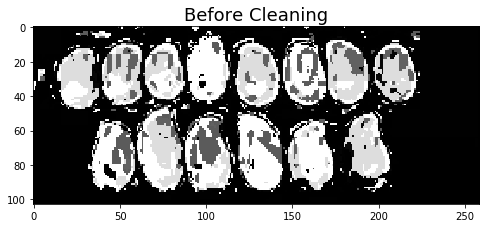

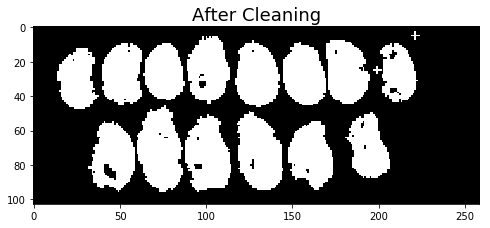

In [11]:
whole = plt.imread('ripe_mangos.png')
patch = plt.imread('ripe_mangos_patch.png')

new_image = segmentation(whole,patch,18)
closing = clean(new_image)

## Finding contours of mangoes using cleaned binary image

In [12]:
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

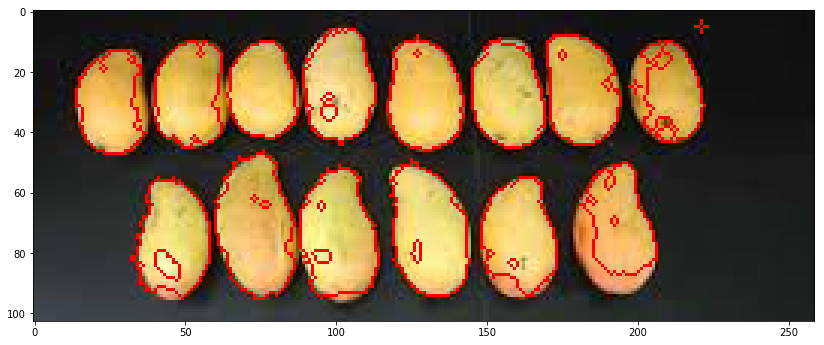

In [13]:
cont_image = np.copy(whole)

im_with_contours = cv2.drawContours(cont_image, contours, -1, (1,0,0), 1)

plt.figure(figsize=(14,10))
plt.imshow(im_with_contours)
# plt.savefig('butterflypeas_contour.png',dpi=300,bbox_inches='tight')
plt.show()

## Fitting an eclipse to each contour and calculating eccentricity from ellipse

In [14]:
eccent = []
cent = []
im_with_ellipse = np.copy(whole)

for c in contours:
    if len(c) < 35:
        continue
    
    moments = cv2.moments(c)
    cx = moments['m10']/moments['m00']
    cy = moments['m01']/moments['m00']
    
    ellipse = cv2.fitEllipse(c)
    center,axes,orientation = ellipse
    maj_axis = max(axes)
    min_axis = min(axes)
    eccentricity = np.sqrt(1-((min_axis/maj_axis)**2))
    
    eccent.append(eccentricity)
    cent.append(np.array([cx,cy],dtype=int))
    
    im_with_ellipse = cv2.ellipse(im_with_ellipse,ellipse,(0,0,1),2)

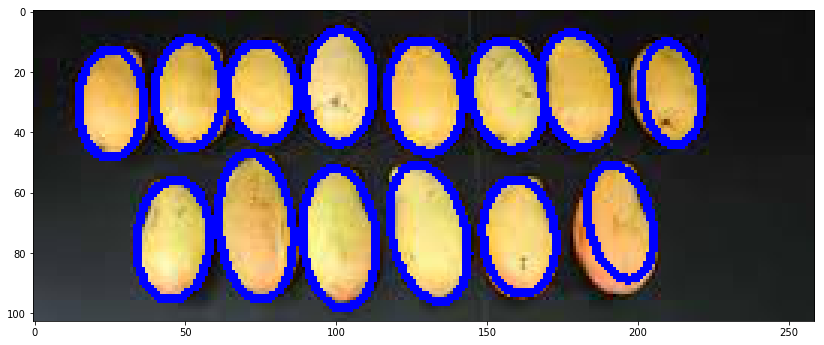

In [15]:
plt.figure(figsize=(14,12))
plt.imshow(im_with_ellipse)
# plt.savefig('butterflypeas_ellipse.png',dpi=300,bbox_inches='tight')
plt.show()

## Calculate NCC of Centroids

In [16]:
r,g,b = RGI(whole)
centroid_r = []
centroid_g = []
centroid_b = []

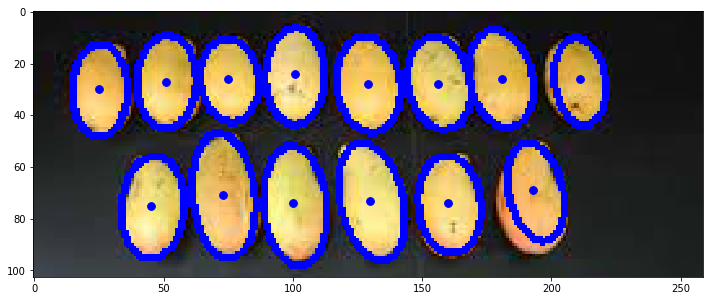

In [17]:
plt.figure(figsize=(12,10))
plt.imshow(im_with_ellipse)

for p in cent:
    plt.scatter(p[0],p[1],c='blue',s=60)
    centroid_r.append(r[p[1],p[0]])
    centroid_g.append(g[p[1],p[0]])
    centroid_b.append(b[p[1],p[0]])

# plt.savefig('ripemango_centroid.png',dpi=300,bbox_inches='tight')
plt.show()

## Create DataFrame of Features of Ripe Mangoes - Set 1

In [18]:
features = pd.DataFrame(columns=['r','g','b','eccentricity'])
features['r'] = centroid_r
features['g'] = centroid_g
features['b'] = centroid_b
features['eccentricity'] = eccent

In [19]:
# features.to_csv('ripemango_features.csv')